# Lets import some things

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms.v2 as transforms


# Decide if cuda

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

cuda


# Load dataset

In [3]:
batchsize = 16
num_classes = 102
learning_rate = 0.0015
num_epochs = 100

In [4]:
trainingData = datasets.Flowers102(
    root="data",
    split = "train",
    download = True,
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        # transforms.RandomResizedCrop((256, 256),antialias=True),
        transforms.RandomRotation(30), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.5,],[0.2,])
    ])
)
testData = datasets.Flowers102(
    root="data",
    split= "test",
    download = True,
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
)
valData = datasets.Flowers102(
    root="data",
    split = "val",
    download = True,
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
)

C:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# Get some dataloaders

In [5]:
train_dataloader = DataLoader(trainingData, batch_size=batchsize, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(testData, batch_size=batchsize, shuffle=False, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(valData, batch_size=batchsize, shuffle=False, num_workers=4, pin_memory=True)

# Neural Network class

In [6]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),#half size
            nn.Conv2d(32,64,kernel_size=5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),#half size
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*64*64 ,4096),
            nn.ReLU(),
            nn.Dropout(), #add a bit of randomness for some fun  + generality
            nn.Linear(4096,102),
            nn.LogSoftmax(dim=1)
        )
        
        
    def forward(self, x):
        x= self.features(x)
        x= x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

# Model = something

In [7]:
model = NeuralNet().to(device,non_blocking=True)
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Actually do the training, needs to print less often

In [8]:
training_epoch_losses = []
def train():
    for epoch in range(num_epochs):
        running_loss = 0.0
        batches = 0
        for i, (images,labels) in enumerate(train_dataloader):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            # images = images.to(device)
            # labels = labels.to(device)
            outputs = model(images)
            optimizer.zero_grad()
            loss = cost(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            batches +=1
        training_epoch_losses.append(running_loss/batches)
        print(f'Epoch: {epoch+1}, Avg Loss: {running_loss/batches:4f}, Num Batches: {batches}')
train()

Epoch: 1, Avg Loss: 4.633003, Num Batches: 64
Epoch: 2, Avg Loss: 4.616152, Num Batches: 64
Epoch: 3, Avg Loss: 4.602245, Num Batches: 64
Epoch: 4, Avg Loss: 4.587397, Num Batches: 64
Epoch: 5, Avg Loss: 4.563112, Num Batches: 64
Epoch: 6, Avg Loss: 4.532539, Num Batches: 64
Epoch: 7, Avg Loss: 4.481226, Num Batches: 64
Epoch: 8, Avg Loss: 4.403786, Num Batches: 64
Epoch: 9, Avg Loss: 4.322232, Num Batches: 64
Epoch: 10, Avg Loss: 4.220958, Num Batches: 64
Epoch: 11, Avg Loss: 4.113497, Num Batches: 64
Epoch: 12, Avg Loss: 4.012945, Num Batches: 64
Epoch: 13, Avg Loss: 3.943701, Num Batches: 64
Epoch: 14, Avg Loss: 3.863554, Num Batches: 64
Epoch: 15, Avg Loss: 3.792663, Num Batches: 64
Epoch: 16, Avg Loss: 3.699913, Num Batches: 64
Epoch: 17, Avg Loss: 3.595262, Num Batches: 64
Epoch: 18, Avg Loss: 3.511514, Num Batches: 64
Epoch: 19, Avg Loss: 3.428761, Num Batches: 64
Epoch: 20, Avg Loss: 3.333068, Num Batches: 64
Epoch: 21, Avg Loss: 3.259229, Num Batches: 64
Epoch: 22, Avg Loss: 3

# Plot the avg loss against epochs

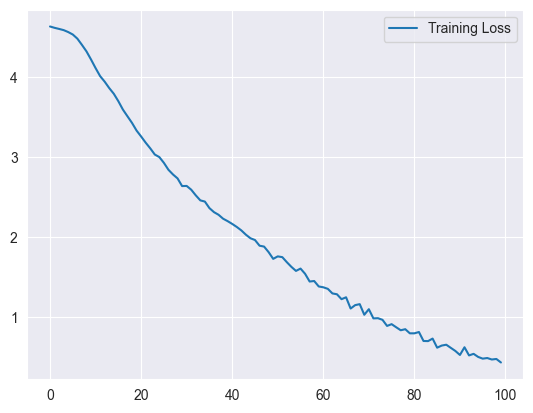

In [9]:
plt.plot(training_epoch_losses, label='Training Loss')
# plt.plot(validation_epoch_losses,label='Validation Loss')   
plt.legend()
plt.show()

# Display the training, testing, validation accuracy

In [10]:
def evaluate(dataloader):
    model.eval()
    correct = 0
    total =0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
        acc= float(100*correct/total)
    return acc
print(f'val acc: {evaluate(val_dataloader):.3f}%')
print(f'test acc: {evaluate(test_dataloader):.3f}%')
print(f'train acc: {evaluate(train_dataloader):.3f}%')

val acc: 27.549%
test acc: 25.533%
train acc: 94.706%


# Save model

In [11]:
def save(pathname):
    torch.save(NeuralNet().state_dict(), f'{pathname}.pth')
    print(f'Saved model to {pathname}.pth')

# Load model

In [12]:
def load(pathname):
    model = NeuralNet().to(device)
    model.load_state_dict(torch.load(f'{pathname}.pth'))
    print(f'Loaded model from {pathname}.pth')

# Command line to convert this notebook to a python file, the reason is for readability of the code from github lol

In [13]:
!jupyter nbconvert --to script Classifier.ipynb

[NbConvertApp] Converting notebook Classifier.ipynb to script
[NbConvertApp] Writing 5271 bytes to Classifier.py


# todo possibly do the image display thing/ https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html / tune hyperparams